Reference paper (not my work) - https://arxiv.org/abs/1901.11103
RNN to learn the potential to density mapping

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
potentials_dict = np.load('./data/Potentials.npz')
densities_dict = np.load('./data/Densities.npz')

In [3]:
potentials = potentials_dict['arr_0']
densities = densities_dict['arr_0']

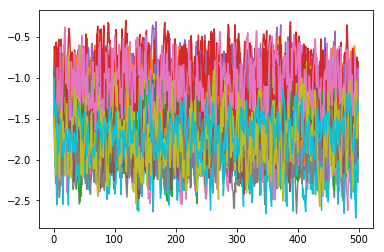

In [4]:
for i in range(len(potentials)):
    plt.plot(potentials[i])

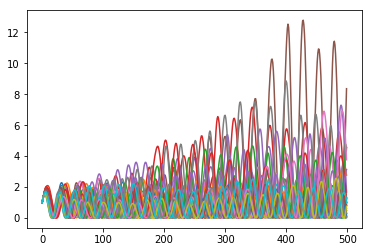

In [5]:
for i in range(len(densities)):
    plt.plot(densities[i])

In [35]:
class PosEncoder(nn.Module):
    def __init__(self):
        super(PosEncoder, self).__init__()
    
    def forward(self, X):
        enc = torch.zeros_like(X)
        for pos in range(X.shape[0]):
            for i in range(X.shape[1]):
                if i % 2 == 0:
                    enc[pos][i] = np.sin(pos/10000**(2*i/X.shape[1]))
                else:
                    enc[pos][i] = np.cos(pos/10000**(2*i/X.shape[1]))
        return X + enc

In [180]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.softmax = nn.Softmax(dim = 1)
    
    def forward(self, Q, K, V, mask):
        assert Q.shape == K.shape
        assert K.shape == V.shape
        assert mask.shape == torch.Size([Q.shape[0], Q.shape[0]])
        d = Q.shape[1]
        out = (1/np.sqrt(d))*torch.matmul(Q, torch.transpose(K, 0, 1))
        out = self.softmax(out*mask)
        out = torch.matmul(out, V)
        return out
        

In [181]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.d = d
        self.dk = d//n_heads
        self.n_heads = n_heads
        self.Lq = [nn.Linear(d, self.dk) for i in range(n_heads)]
        self.Lk = [nn.Linear(d, self.dk) for i in range(n_heads)]
        self.Lv = [nn.Linear(d, self.dk) for i in range(n_heads)]
        self.Lo = nn.Linear(self.dk*self.n_heads, self.d)
        self.attn = [Attention() for i in range(n_heads)]
        
    def forward(self, Q, K, V, mask):
        Qp = [self.Lq[i](Q) for i in range(self.n_heads)]
        Kp = [self.Lk[i](K) for i in range(self.n_heads)]
        Vp = [self.Lv[i](V) for i in range(self.n_heads)]
        heads = [self.attn[i](Qp[i], Kp[i], Vp[i], mask) for i in range(self.n_heads)]
        out = self.Lo(torch.cat(heads, dim = 1))
        return out
        

In [182]:
class FFNet(nn.Module):
    def __init__(self, d, dff):
        super(FFNet, self).__init__()
        self.L1 = nn.Linear(d, dff)
        self.L2 = nn.Linear(dff, d)
    
    def forward(self, X):
        out = self.L2(F.relu(self.L1(X)))
        return out

In [183]:
class EncoderLayer(nn.Module):
    def __init__(self, d, n_heads, dff):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadAttention(d, n_heads)
        self.ln1 = nn.LayerNorm(d)
        self.ffn = FFNet(d, dff)
        self.ln2 = nn.LayerNorm(d)
        
    def forward(self, X):
        out = self.ln1(X + self.attn(X, X, X, torch.ones(X.shape[0], X.shape[0])))
        out = self.ln2(out + self.ffn(X))
        return out  

In [184]:
class Encoder(nn.Module):
    def __init__(self, d, n_heads, dff, n_layers):
        super(Encoder, self).__init__()
        self.layers = [EncoderLayer(d, n_heads, dff) for i in range(n_layers)]
    
    def forward(self, X):
        out = self.layers[0](X)
        for i in range(1, len(self.layers)):
            out = self.layers[i](out)
        return out

In [185]:
class DecoderLayer(nn.Module):
    def __init__(self, d, n_heads, dff):
        super(DecoderLayer, self).__init__()
        self.attn1 = MultiHeadAttention(d, n_heads)
        self.attn2 = MultiHeadAttention(d, n_heads)
        self.ln1 = nn.LayerNorm(d)
        self.ffn = FFNet(d, dff)
        self.ln2 = nn.LayerNorm(d)
        self.ln3 = nn.LayerNorm(d)
        
    def forward(self, X, enc_out):
        mask = torch.ones(X.shape[0], X.shape[0])
        for i in range(X.shape[0]):
            for j in range(i, X.shape[0]):
                mask[i][j] = -1e20
        out = self.ln1(X + self.attn1(X, X, X, mask))
        mask = torch.ones(X.shape[0], X.shape[0])
        out = self.ln2(out + self.attn2(out, enc_out, enc_out, mask))
        out = self.ln3(out + self.ffn(out))
        return out  

In [186]:
class Decoder(nn.Module):
    def __init__(self, input_size, d, n_heads, dff, n_layers):
        super(Decoder, self).__init__()
        self.layers = [DecoderLayer(d, n_heads, dff) for i in range(n_layers)]
        self.L = nn.Linear(d, input_size)
    
    def forward(self, X, enc_out):
        out = self.layers[0](X, enc_out)
        for i in range(1, len(self.layers)):
            out = self.layers[i](out, enc_out)
        out = self.L(out)
        return out 

In [187]:
class Transformer(nn.Module):
    def __init__(self, input_size, d, n_heads, dff, n_layers):
        super(Transformer, self).__init__()
        self.pos_enc = PosEncoder()
        self.enc = Encoder(d, n_heads, dff, n_layers)
        self.dec = Decoder(input_size, d, n_heads, dff, n_layers)
    
    def forward(self, X, Y):
        enc_out = self.enc(self.pos_enc(X))
        out = self.dec(self.pos_enc(Y), enc_out)
        return out

In [188]:
batch_size = 10
input_size = 1
d = 4
n_heads = 2
dff = 128
n_layers = 2
model = Transformer(input_size, d, n_heads, dff, n_layers)
# model.to(device)

In [189]:
X = torch.zeros(batch_size, d)
Y = torch.zeros(batch_size, d)
for i in range(batch_size):
    X[i] = torch.tensor([potentials[0][i]**j for j in range(d)], dtype = torch.float)
    Y[i] = torch.tensor([densities[0][i]**j for j in range(d)], dtype = torch.float)
# X = X.to(device)
# Y = Y.to(device)

In [190]:
X.size()

torch.Size([10, 4])

In [191]:
criterion = nn.MSELoss()
out = model(X, Y)
loss = criterion(out, Y[:,1])
print(out.shape)
print(loss)

torch.Size([10, 1])
tensor(5.0030, grad_fn=<MseLossBackward>)


In [170]:
list(model.enc.layers[0])

[Encoder()]

In [108]:
out

tensor([[1.2931],
        [1.1628],
        [1.3671],
        [1.2605],
        [1.0744],
        [0.9644],
        [0.8573],
        [0.7753],
        [0.7533],
        [0.7939]], grad_fn=<AddmmBackward>)

In [109]:
Y[:,1]

tensor([1.0000, 1.1999, 1.3941, 1.5736, 1.7301, 1.8602, 1.9568, 2.0121, 2.0214,
        1.9810])

In [110]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [111]:
device

device(type='cuda', index=0)

In [113]:
n_seq = len(potentials)
seq_len = len(potentials[0])
n_train = 20

In [114]:
X_train = np.array([potentials[i][j*batch_size:(j + 1)*batch_size] for i in range(n_train) for j in range(1, seq_len//batch_size)])
X_train.shape

(980, 10)

In [116]:
Y_train = np.array([densities[i][j*batch_size:(j + 1)*batch_size] for i in range(n_train) for j in range(1, seq_len//batch_size)])
Y_train.shape

(980, 10)

In [129]:
def get_batch(X_train, Y_train, d):
    batch_size = X_train.shape[1] 
    x = torch.zeros((batch_size, d))
    y = torch.zeros((batch_size, d))
    idx = np.random.randint(0, X_train.shape[0])
    for i in range(batch_size):
        x[i] = torch.tensor([X_train[idx][i]**j for j in range(d)])
        y[i] = torch.tensor([Y_train[idx][i]**j for j in range(d)])
    return (x, y)    

In [130]:
x, y = get_batch(X_train, Y_train, d)
x.shape

torch.Size([10, 4])

In [192]:
model = Transformer(input_size, d, n_heads, dff, n_layers)
# model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay = 10)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.MSELoss()
loss_vals = []
n_iters = X_train.shape[0]

In [193]:
epochs = 10
avg_loss = 0
for e in range(epochs):
    avg_loss = 0
    for i in range(n_iters):
        data, target = get_batch(X_train, Y_train, d)
#         data = data.to(device)
#         target = target.to(device)
        out = model(data, target)
        optimizer.zero_grad()
        loss = criterion(out, target[:, 1])
        loss.backward()
        loss_vals.append(loss.item())
        avg_loss += loss_vals[-1]
        optimizer.step()
        
    avg_loss /= len(X_train)
    print('Epoch = {}, avg loss = {:.3}'.format(e, avg_loss))

Epoch = 0, avg loss = 2.26
Epoch = 1, avg loss = 2.57
Epoch = 2, avg loss = 2.4
Epoch = 3, avg loss = 2.05
Epoch = 4, avg loss = 2.64
Epoch = 5, avg loss = 2.61
Epoch = 6, avg loss = 2.02
Epoch = 7, avg loss = 2.47
Epoch = 8, avg loss = 2.38
Epoch = 9, avg loss = 2.54


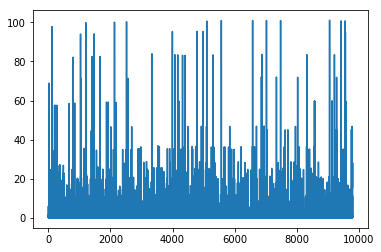

In [195]:
plt.plot(loss_vals)

In [196]:
loss_vals[-10:-1]

[0.1946825087070465,
 1.2142184972763062,
 0.23248951137065887,
 0.061230480670928955,
 11.319147109985352,
 0.13720208406448364,
 0.20418179035186768,
 0.6655629277229309,
 28.165983200073242]

In [197]:
out

tensor([[0.6058],
        [0.6238],
        [0.6236],
        [0.6229],
        [0.6129],
        [0.5872],
        [0.5893],
        [0.5908],
        [0.6018],
        [0.6023]], grad_fn=<AddmmBackward>)

In [199]:
target[:1]

tensor([[1.0000e+00, 5.4264e-02, 2.9445e-03, 1.5978e-04]])

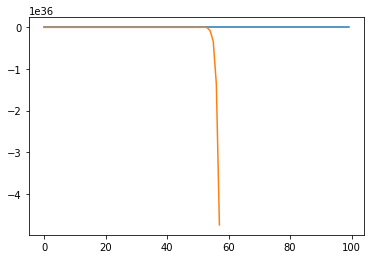

In [153]:
i = 5
y = densities[i]
X_test = [potentials[i][j*n_steps:(j + 1)*n_steps] for j in range(seq_len//n_steps)]
yh = []
for i in range(len(X_test)):
    data, target = get_batch(X)
    data = torch.unsqueeze(torch.as_tensor(X_test[i], dtype = torch.float), dim = 1)
    data = data.to(device)
    for j in range(data.shape[0]):
        out = model(data[j])
        yh.append(out.detach().cpu().numpy())
#     print(model.h)
#     model.init_hidden()

plt.figure()
plt.plot(y[:100])
plt.plot(np.array(yh)[:100])

In [801]:
model.W

Parameter containing:
tensor([[[ 0.9528,  0.9562,  0.9531,  0.9525],
         [ 0.9552,  0.9546,  0.9517,  0.9497],
         [ 0.9643,  0.9567,  0.9490,  0.9584],
         [ 0.9603,  0.9571,  0.9574,  0.9545]],

        [[ 0.0347,  0.0339,  0.0362,  0.0321],
         [ 0.0358,  0.0329,  0.0351,  0.0309],
         [ 0.0350,  0.0364,  0.0374,  0.0370],
         [ 0.0357,  0.0355,  0.0350,  0.0328]],

        [[-0.0280, -0.0298, -0.0248, -0.0227],
         [-0.0250, -0.0220, -0.0250, -0.0232],
         [-0.0248, -0.0257, -0.0257, -0.0287],
         [-0.0255, -0.0314, -0.0317, -0.0274]],

        [[ 0.0205,  0.0175,  0.0198,  0.0176],
         [ 0.0217,  0.0181,  0.0187,  0.0160],
         [ 0.0181,  0.0210,  0.0245,  0.0167],
         [ 0.0220,  0.0162,  0.0183,  0.0169]]], device='cuda:0',
       requires_grad=True)

In [802]:
model.p

Parameter containing:
tensor([ 0.9536, -0.0464, -0.0467, -0.0467], device='cuda:0',
       requires_grad=True)

In [113]:
model.h

tensor([1., 1., 1., 1., 1., 1.], device='cuda:0')